In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sps
from scipy import stats

sys.path.append("../")

In [174]:
import lusim as sim
import network as nn
import objective as obj
import optimize as opt
import project_utilities as utils
from draw_neural_net import draw_neural_net, draw_weighted_neural_net, get_rgb

In [175]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [176]:
rng = np.random.default_rng(seed=6875)

# Grid Definition

In [177]:
nx = 500
# nx = 1000
ny = 1
x0 = 0.5
y0 = 0.5
dx = 1
dy = 1
nxy = nx * ny

X, Y = np.meshgrid(
    np.linspace(x0, x0 + (nx - 1) * dx, nx),
    np.linspace(y0, y0 + (ny - 1) * dy, ny),
)
P = np.concatenate((X.reshape(nxy, 1), Y.reshape(nxy, 1)), axis=1)

# Target Variogram Model
- 0.1, 0.5, 0.9 quantiles

In [178]:
quantiles = [0.1, 0.5, 0.9]
yc = stats.norm.ppf(quantiles)
print(yc)

[-1.28155157  0.          1.28155157]


In [179]:
thresholds = {q: t for q, t in zip(quantiles, stats.norm.ppf(quantiles))}
thresholds

{0.1: -1.2815515655446004, 0.5: 0.0, 0.9: 1.2815515655446004}

In [180]:
vtype_it = [[2], [2], [2]]
xranges_it = [[150], [100], [25]]
cc_i = [[1.0], [1.0], [1.0]]
nst_i = len(vtype_it[0])

c0 = 0.0
cmax = [c0 + np.sum(cc_i[q]) for q in range(len(quantiles))]
print(cmax)

[1.0, 1.0, 1.0]


In [181]:
EPS = 1e-5
covas = {q: np.zeros((nxy, nxy)) for q in quantiles}
for i, q in enumerate(quantiles):
    for j in range(nst_i):
        Q = P.copy()
        Q[:, 0] = Q[:, 0] / xranges_it[i][j]
        d = sps.distance_matrix(Q, Q)
        covas[q] = covas[q] + cc_i[i][j] * sim.covar(vtype_it[i][j], d, r=1)
    covas[q][d < EPS] = cmax[i]

In [182]:
ivarios = {}
for q in quantiles:
    ivarios[f"{q}_x"] = 1 - covas[q][0:nx, 0]

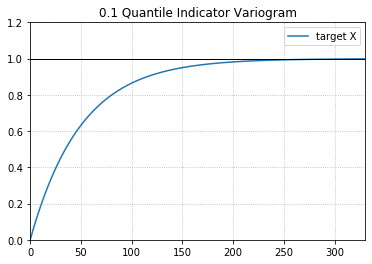

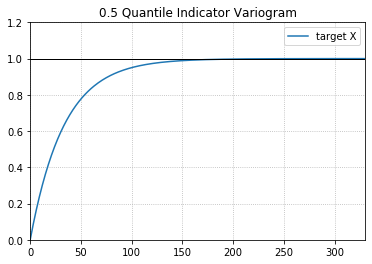

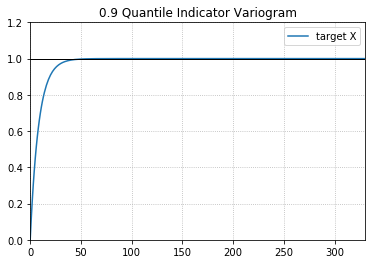

In [183]:
for q in quantiles:
    fig, ax = plt.subplots()
    ax.plot(ivarios[f"{q}_x"], label="target X")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * 0.66)
    ax.legend()

In [184]:
vtype_t = [2, 2]
xranges_t = [25, 150]
# xranges_t = [50, 300]
c0 = 0.001
cc = [0.5, 0.499]
cmax = c0 + np.sum(cc)
nst = len(vtype_t)

In [185]:
EPS = 1e-5
cova = np.zeros((nxy, nxy))
for i in range(nst):
    Q = P.copy()
    Q[:, 0] = Q[:, 0] / xranges_t[i]
    d = sps.distance_matrix(Q, Q)
    cova = cova + cc[i] * sim.covar(vtype_t[i], d, r=1)
cova[d < EPS] = cmax

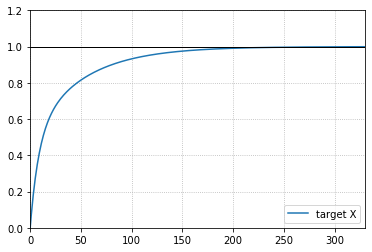

In [186]:
target_x = 1 - cova[0:nx, 0]

fig, ax = plt.subplots()
ax.plot(target_x, label="target X")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.66)
ax.legend(loc=4)

# Factor Variogram Models

In [187]:
sph_fact = 5
exp_fact = 5
gau_fact = 5
n_fact = sph_fact + exp_fact + gau_fact

max_range = int(nx * 0.25)
min_range = int(nx * 0.025)

sph_ranges = np.linspace(min_range, max_range, num=sph_fact, endpoint=False)
exp_ranges = np.linspace(min_range, max_range, num=exp_fact, endpoint=False)
gau_ranges = np.linspace(min_range, max_range, num=gau_fact, endpoint=False)

sph_struct = [1] * sph_fact
exp_struct = [2] * exp_fact
gau_struct = [3] * gau_fact

ranges = np.concatenate((sph_ranges, exp_ranges, gau_ranges))
structs = np.concatenate((sph_struct, exp_struct, gau_struct))

In [188]:
structs

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [189]:
ranges

array([ 12. ,  34.6,  57.2,  79.8, 102.4,  12. ,  34.6,  57.2,  79.8,
       102.4,  12. ,  34.6,  57.2,  79.8, 102.4])

In [190]:
for i, (st, rnge) in enumerate(zip(structs, ranges)):
    print(i + 1, st, rnge)

1 1 12.0
2 1 34.6
3 1 57.2
4 1 79.80000000000001
5 1 102.4
6 2 12.0
7 2 34.6
8 2 57.2
9 2 79.80000000000001
10 2 102.4
11 3 12.0
12 3 34.6
13 3 57.2
14 3 79.80000000000001
15 3 102.4


# Factor Simulation
- Each initial factor is simulated with a different random number seed and a completely different variogram
- Each initial factor has a single pure structure that reflects something with unique spatial correlation that could translate to something combined with other factors

In [191]:
Y = np.zeros([nxy, n_fact + 1])
Y[:, 0] = rng.normal(size=nxy)
C = []
for i, (st, rnge) in enumerate(zip(structs, ranges)):
    if st < 3:
        cova = sim.pairwisecova_1D(
            P, ranges=[rnge], vtypes=[st], c0=0.0, cc=[1.0]
        )
    else:  # small nugget to avoid singular matrix with Gaussian model
        cova = sim.pairwisecova_1D(
            P, ranges=[rnge], vtypes=[st], c0=0.001, cc=[0.999]
        )
    Y[:, i + 1] = sim.lusim(cova, nr=1, seed=78451 + i * 1000)
    C.append(cova)

In [192]:
Y.shape

(500, 16)

-0.05 0.98
-0.15 1.06
-0.01 0.87
-0.38 1.35
0.27 1.08
-0.21 0.76
0.18 0.9
0.07 1.04
0.06 0.84
0.08 0.86
-0.13 0.71
0.11 0.87
-0.15 0.89
-0.04 0.78
-0.39 0.67
-0.52 1.05


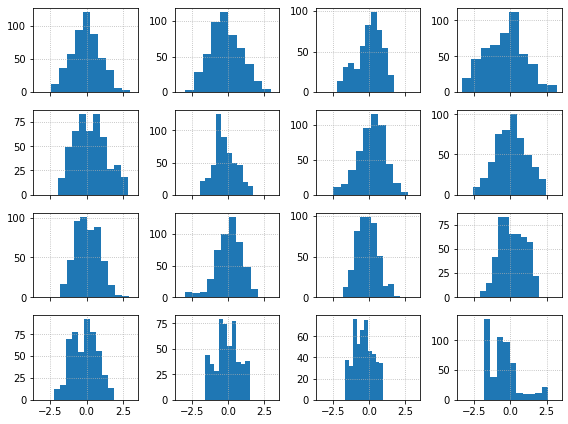

In [193]:
fig, axes = plt.subplots(4, 4, figsize=(8, 6), sharex="all")
for i, ax in enumerate(axes.flatten()):
    ax.hist(Y[:, i])
    print(np.round(np.mean(Y[:, i]), 2), np.round(np.std(Y[:, i]), 2))
fig.tight_layout()

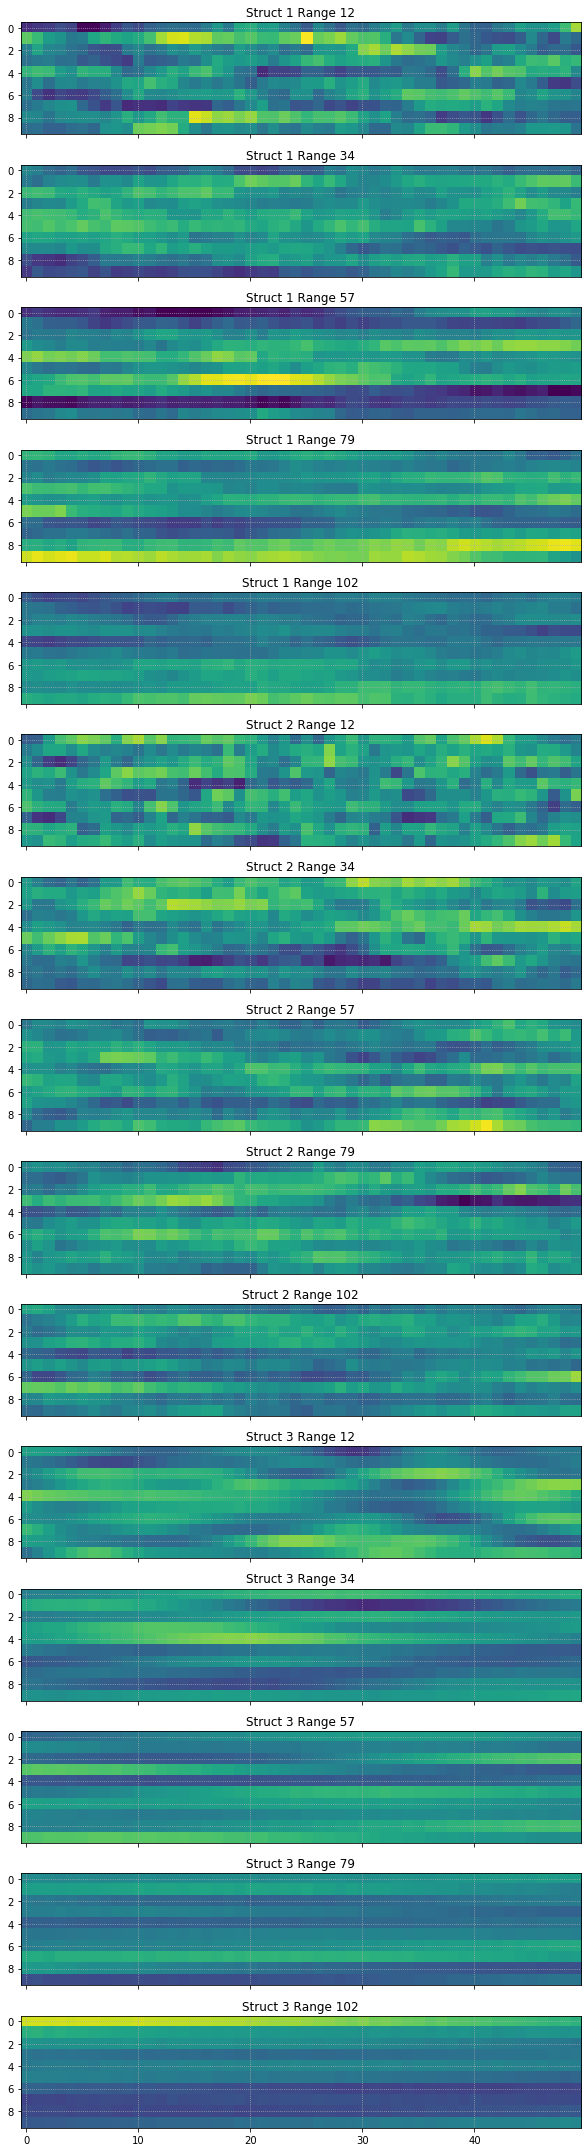

In [195]:
fig, axes = plt.subplots(15, 1, figsize=(10, 30), sharex="all")
for i, (ax, st, rnge) in enumerate(zip(axes.flatten(), structs, ranges)):
    ax.imshow(Y[:, i + 1].reshape(10, 50), vmin=-3, vmax=3)
    ax.set_title(f"Struct {st} Range {int(rnge)}")
fig.tight_layout()

# Network LMR
- Mix the pool of factors with the goal of reproducing the LMR
- Exponential factors of short and long-ish ranges should recive the most weight

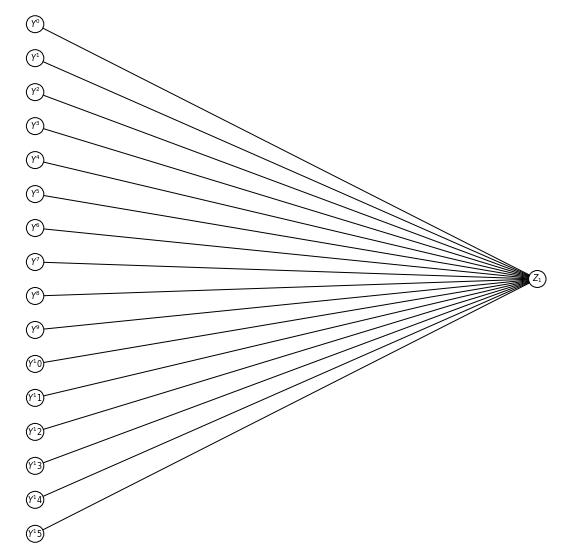

In [196]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
layer_dims = [n_fact + 1, 1]
# layer_dims = [n_fact + 1, 5, 5, 5, 1]
draw_neural_net(ax, 0.05, 0.95, 0.0, 1.0, layer_dims, "Y", "A", "Z", 8)

In [197]:
parameters = nn.intitialize_layer_params(layer_dims, 69420)

In [198]:
connections = []
for k, v in parameters.items():
    if "W" in k:
        connections.append(v.shape[0] * v.shape[1])
    print(k, "shape:", v.shape)
tconn = np.sum(connections)
print("Total connections:", tconn)

W1 shape: (1, 16)
b1 shape: (1, 1)
Total connections: 16


In [199]:
from nscore import NormalScoreTransformer

AL = nn.linear_forward(Y, parameters, nn.relu)
# AL = NormalScoreTransformer().transform(AL.squeeze())

In [200]:
AL.shape

(500,)

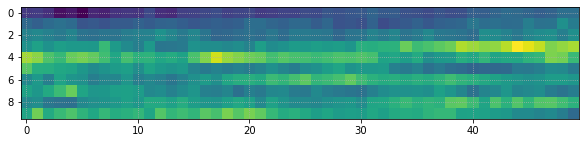

In [203]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(AL.reshape(10, 50), vmin=-3, vmax=3)

In [204]:
AL_i, ivars = obj.indicator_transform(AL, yc)

0.09000000000000001
0.25
0.08999999999999998


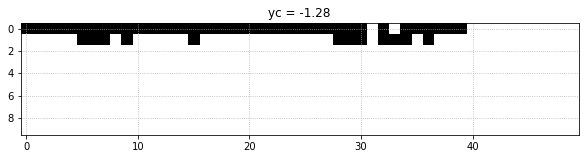

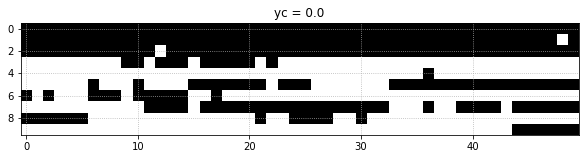

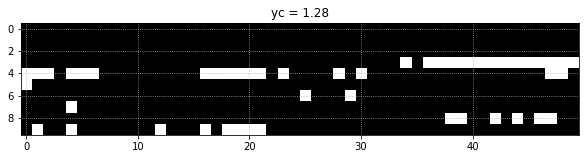

In [207]:
for j, c in enumerate(yc):
    fig, ax = plt.subplots(figsize=(10, 9))
    print(ivars[j])
    im = ax.imshow(AL_i[:, j].reshape(10, 50), vmin=0, vmax=1, cmap="binary")
    plt.title(f"yc = {np.round(c, 2)}")

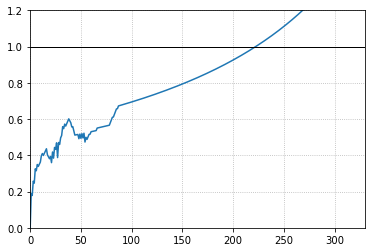

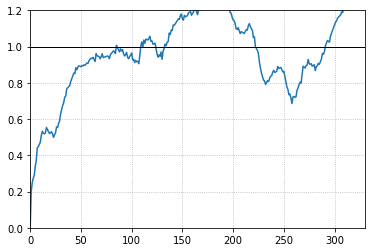

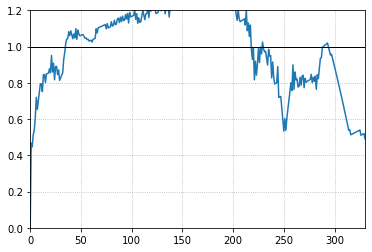

In [208]:
for j, c in enumerate(yc):
    fig, ax = plt.subplots()
    gx = obj.griddedgam(AL_i[:, j])
    ax.plot(gx / ivars[j])
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * 0.66)

In [209]:
obj.objective_ivario(
    true=ivarios,
    pred=AL_i,
    nx=nx,
    ny=1,
    i=0,
    j=nx - 1,
    quantiles=quantiles,
    ivars=ivars,
    scale=1.0,
)

60.38123121742771

In [210]:
thresholds

{0.1: -1.2815515655446004, 0.5: 0.0, 0.9: 1.2815515655446004}

In [211]:
def check_twod(z):
    twod = False
    ndim = z.shape
    if len(ndim) > 1:
        if ndim[1] > 1:
            twod = True
    return twod


def griddedgam(z):
    """gridded variogram values"""
    if check_twod(z):
        gx = griddedgam_x(z)
        gy = griddedgam_y(z)
        return gx, gy
    else:
        return griddedgam_x(z)


def griddedgam_x(z):
    """gridded variogram values along x axis"""
    nx = z.shape[0]
    gx = np.zeros(nx - 1)
    for i in range(1, nx - 1):
        z0 = z[0 : nx - i]
        z1 = z[i:nx]
        dz = (z1 - z0) ** 2
        gx[i] = np.sum(dz) / (2 * (nx - i))
    return gx


def griddedgam_y(z):
    """gridded variogram values along y axis"""
    ny = z.shape[1]
    gy = np.zeros(ny - 1)
    for i in range(1, ny - 1):
        z0 = z[0 : ny - i, :]
        z1 = z[i:ny, :]
        dz = (z1 - z0) ** 2
        gy[i] = np.sum(dz) / (2 * (ny - i))
    return gy


def vario_loss(true, pred, i, j):
    """squared error between predicted and target variogram"""
    return np.sum((pred[i:j] - true[i:j]) ** 2)

In [212]:
def vector_to_matrices(parameters, connections, x):
    """reshape 1D vector into appropriate matrices"""
    L = len(parameters) // 2
    num_wts = np.cumsum([0] + connections)
    for ell in range(1, L + 1):
        shape = parameters["W" + str(ell)].shape
        parameters["W" + str(ell)] = x[num_wts[ell - 1] : num_wts[ell]].reshape(
            shape
        )
    return parameters


def indicator_transform(z, zc):
    """indicator transform of z based on cutoffs zc"""
    z = z.flatten()
    zi = np.zeros((len(z), len(zc)))
    ivars = []
    for j, c in enumerate(zc):
        zi[:, j] = np.where(z <= c, 1, 0)
        iprop = np.mean(zi[:, j])
        ivars.append(iprop * (1 - iprop))
    return zi, ivars

In [213]:
def objective_vario(AL, target, nx, ny, i, j, scale=1.0):
    """continuous variogram objective function"""
    twod = False
    if ny > 1:
        twod = True
    objv = 0.0
    if twod:
        tx, ty = target[:, 0], target[:, 1]
        gx, gy = griddedgam(AL.reshape(ny, nx))
        objv = vario_loss(tx, gx, i, j)
        objv += vario_loss(ty, gy, i, j)
    else:
        gx = griddedgam(AL)
        objv = vario_loss(target, gx, i, j)
    return objv * scale


def init_vario(
    Y, target, nx, ny, connections, parameters, bounds, afunc, seed,
):
    """initialize continuous variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_vario(AL, target, nx, ny, i=0, j=nx - 1, scale=1.0)
    return objv


def objective_ivario(AL, target, thresholds, nx, ny, ii, jj, scale=1.0):
    """indicator variogram objective function"""
    twod = False
    if ny > 1:
        twod = True
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    objv = 0.0
    if twod:
        for k, q in enumerate(quantiles):
            tx, ty = target[f"{q}_x"], target[f"{q}_y"]
            gx, gy = griddedgam(AL_i[:, k].reshape(ny, nx))
            objv = vario_loss(tx, gx / ivars[k], ii[k], jj[k])
            objv += vario_loss(ty, gy / ivars[k], ii[k], jj[k])
    else:
        for k, q in enumerate(quantiles):
            gx = griddedgam(AL_i[:, k])
            objv = vario_loss(target[f"{q}_x"], gx / ivars[k], ii[k], jj[k])
    return objv * scale


def init_ivario(
    Y, target, nx, ny, thresholds, connections, parameters, bounds, afunc, seed,
):
    """initialize indicator variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_ivario(
        AL,
        target,
        thresholds,
        nx,
        ny,
        ii=[0] * len(thresholds),
        jj=[nx - 1] * len(thresholds),
        scale=1.0,
    )
    return objv


def init_runs():
    pass


def init_npoint():
    pass

In [214]:
def objective_scaling(
    Y,
    nx,
    ny,
    connections,
    parameters,
    bounds,
    afunc,
    maxpert,
    seed,
    vario=True,
    vario_target=None,
    ivario=True,
    ivario_target=None,
    runs=False,
    runs_target=None,
    npoint=False,
    npoint_target=None,
):
    rng = np.random.default_rng(seed)

    objinit = np.zeros(4)
    objscale = np.ones(4)
    objdelta = np.zeros(4)

    # initalize objective values
    if vario:
        objinit[0] = init_vario(
            Y,
            vario_target,
            nx,
            ny,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if ivario:
        objinit[1] = init_ivario(
            Y,
            ivario_target,
            nx,
            ny,
            thresholds,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if runs:
        pass
    if npoint:
        pass

    for m in range(maxpert):

        # draw random parameter vector
        x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))

        # reshape x into matrices
        parameters = vector_to_matrices(parameters, connections, x)

        # caluclate the forward pass
        AL = nn.linear_forward(Y, parameters, afunc)

        # approximate objective contributions
        if vario:
            temp_obj_vario = objective_vario(
                AL, vario_target, nx, ny, i=0, j=nx-1, scale=objscale[0]
            )
            if temp_obj_vario < 0.0:
                temp_obj_vario = objinit[0]
            objdelta[0] += np.abs(objinit[0] - temp_obj_vario)

        if ivario:
            temp_obj_ivario = objective_ivario(
                AL,
                ivario_target,
                thresholds,
                nx,
                ny,
                ii=[0] * len(thresholds),
                jj=[nx-1] * len(thresholds),
                scale=objscale[1],
            )
            if temp_obj_ivario < 0.0:
                temp_obj_ivario = objinit[1]
            objdelta[1] += np.abs(objinit[1] - temp_obj_ivario)

        if runs:
            pass
        if npoint:
            pass

    # scale objective components
    if vario:
        objscale[0] = maxpert / objdelta[0]
    if ivario:
        objscale[1] = maxpert / objdelta[1]
    if runs:
        pass
    if npoint:
        pass

    # rescale factor
    rescale = 0.0
    for objv, scl in zip(objinit, objscale):
        rescale += scl * objv
    rescale = 1 / max(rescale, 1e-10)
    objscale *= rescale

    return objscale

In [215]:
afunc = nn.linear
bounds = (0, 1)
objscale = objective_scaling(
    Y,
    nx,
    ny,
    connections,
    parameters,
    bounds,
    afunc,
    maxpert=1000,
    seed=123,
    vario=True,
    vario_target=target_x,
    ivario=True,
    ivario_target=ivarios,
)
print(objscale)

[0.00475396 0.00341066 0.47510484 0.47510484]


In [216]:
sum(objscale)

0.9583742960338115

In [217]:
def network_lmr_objective_1D(x, *args):
    """objective function for network lmr"""

    # caluclate the forward pass
    params = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, params, afunc)

    # calculate sum of squares
    objv = 0.0

    # continuous variogram
    objv += objective_vario(AL, target_vario, nx, ny, i, j, objscale[0])

    # indicator variogram
    objv += objective_ivario(
        AL, target_ivario, thresholds, nx, ny, ii, jj, objscale[1]
    )

    return objv

In [218]:
target_vario = target_x
target_ivario = ivarios
i = 0
j = 200
ii = [0, 0, 0]
# jj = [a for b in xranges_it for a in b]
jj = [250, 200, 100]
objscale = [1, 1, 0, 0]

args = (
    parameters,
    connections,
    Y,
    nx,
    ny,
    i,
    j,
    ii,
    jj,
    target_vario,
    target_ivario,
    thresholds,
    afunc,
    objscale,
)
results = list(
    opt.de(
        network_lmr_objective_1D,
        args,
        bounds=[bounds] * tconn,
        popsize=15,
        mut=0.7,
        crossp=0.9,
        its=200,
        seed=21,
    )
)

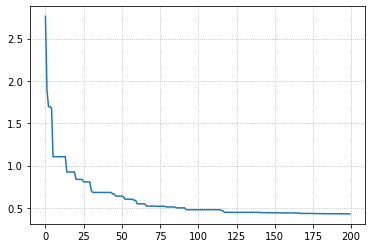

In [219]:
objective = []
for result in results:
    objective.append(result[-1])
plt.plot(objective)

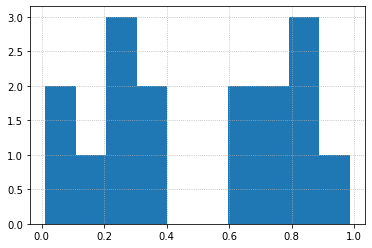

In [220]:
_ = plt.hist(results[-1][0])

In [221]:
results[-1]

(array([0.34294596, 0.26096644, 0.72543985, 0.22173368, 0.01158634,
        0.14649768, 0.87147646, 0.10426453, 0.62002348, 0.2497889 ,
        0.85179282, 0.83496207, 0.78229984, 0.60750787, 0.31268123,
        0.98663294]),
 0.4300478801658187)

In [222]:
len(results)

200

In [223]:
de_params = parameters.copy()
de_weights = []
num_wts = np.cumsum([0] + connections)
for ell in range(1, len(parameters) // 2 + 1):
    shape = de_params["W" + str(ell)].shape
    de_params["W" + str(ell)] = results[-1][0][
        num_wts[ell - 1] : num_wts[ell]
    ].reshape(shape)
    de_weights.append(de_params["W" + str(ell)])

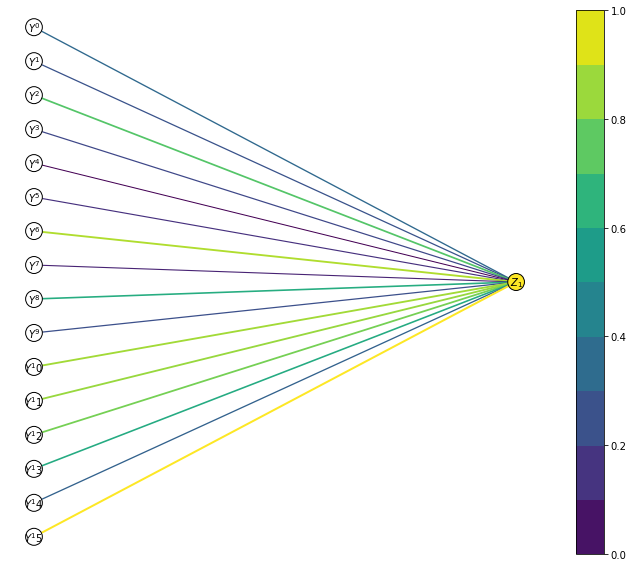

In [224]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")
cmap = "viridis"  # "Spectral_r"
draw_weighted_neural_net(
    ax,
    0.05,
    0.95,
    0.0,
    1.0,
    layer_dims,
    "Y",
    "A",
    "Z",
    10,
    node_wts=de_weights,
    edge_wts=de_weights,
    cmap=cmap,
)
sm, _ = get_rgb(0, cmap, 0, 1)
plt.colorbar(sm, boundaries=np.arange(0, 1.1, 0.1))

In [225]:
de_AL = nn.linear_forward(Y, de_params, afunc)
de_AL_i, ivars = obj.indicator_transform(de_AL, yc)
gx = obj.griddedgam(de_AL)

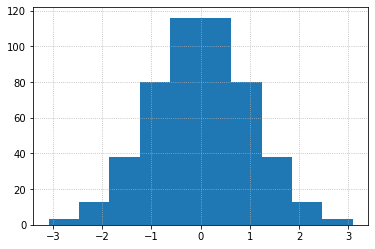

In [226]:
_ = plt.hist(de_AL)

In [227]:
def core_tray_plot(
    z, len_rows, nrows, cmap="viridis", clim=(-2.5, 2.5), figsize=(10, 3)
):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(
        z.reshape(nrows, len_rows), vmin=clim[0], vmax=clim[1], cmap=cmap
    )
    plt.colorbar(im, ax=ax)
    return ax

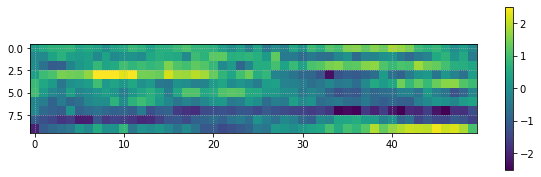

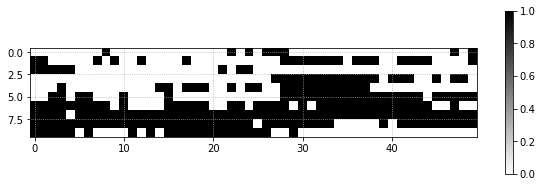

In [228]:
core_tray_plot(de_AL, 50, 10)
core_tray_plot(
    np.where(de_AL > thresholds[0.5], 0, 1),
    cmap="binary",
    clim=(0, 1),
    len_rows=50,
    nrows=10,
)

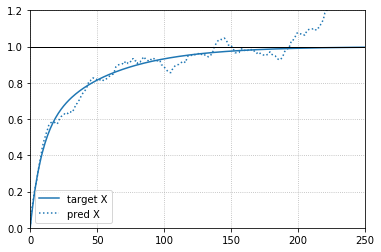

In [229]:
fig, ax = plt.subplots()
ax.plot(target_vario, c="C0", label="target X")
ax.plot(gx, c="C0", ls=":", label="pred X")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.5)
ax.legend()

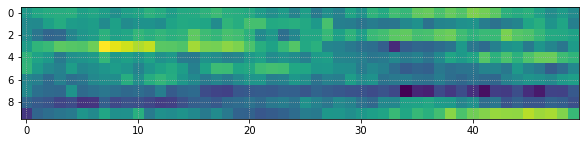

In [230]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(de_AL.reshape(10, 50), vmin=-3, vmax=3)

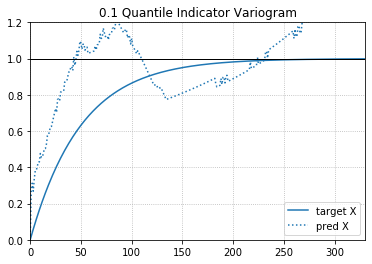

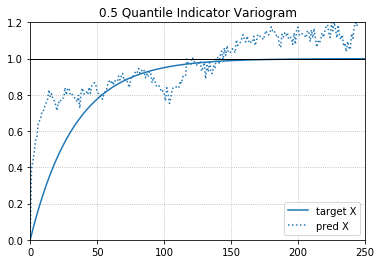

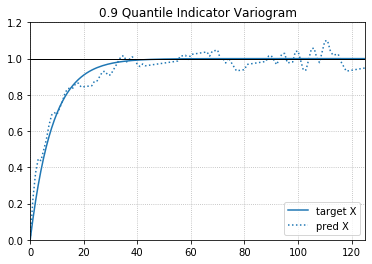

In [231]:
xscale = [0.66, 0.5, 0.25]
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    gxi = griddedgam(de_AL_i[:, j])
    ax.plot(target_ivario[f"{q}_x"], c="C0", label="target X")
    ax.plot(gxi / ivars[j], c="C0", ls=":", label="pred X")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * xscale[j])
    ax.legend()

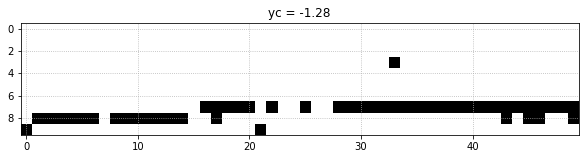

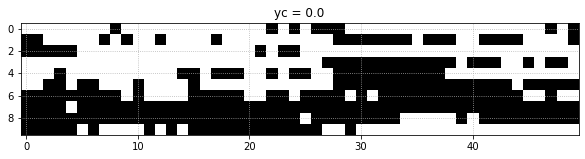

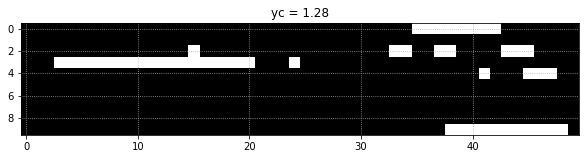

In [232]:
for j, c in enumerate(yc):
    fig, ax = plt.subplots(figsize=(10, 9))
    im = ax.imshow(de_AL_i[:, j].reshape(10, 50), vmin=0, vmax=1, cmap="binary")
    plt.title(f"yc = {np.round(c, 2)}")

In [233]:
# save mixture for subseuquent notebooks
np.save("network_mixture", de_AL)
np.save("network_mixture_indicators", de_AL_i)